## In this Tutorial we will be modeling an RNA Polymerase (RNAP)

### The structure is available here https://www.rcsb.org/structure/6ASX

### This System contains both RNA and Protein, to prepare it for simulation we must do the following:

    1. Separate the RNA and Protein components of the system into separate PDB structures
        (this step is done in chimera)
        
    2. Convert each component to oxDNA format
    
    3. Combine into a single system
    
    4. Simulate

In [2]:
import models as m # If this fails see the Setup Notebook
import os

### 1. Separate RNA and Protein Components 
    
    ->Open 6asx.pdb in Chimera, select the RNA chains and save as PDB
    ->Select the Protein chains and save as PDB
    
    The separated PDB files are provided as (RNA.pdb -> RNA Component) and (RNAP.pdb -> Protein Component)

### 2a. Protein Conversion into oxDNA format

INFO: Don't worry about Discontinuous chain warnings!


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 25950.
  warnings.warn(


INFO: N = 3179


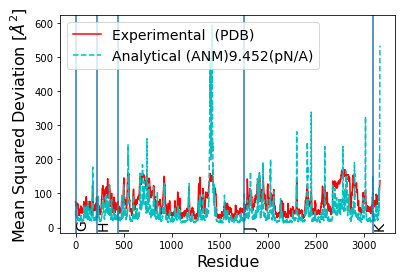

In [3]:
wdir = os.getcwd()

# Let's Try to build an ANM network for this 


coord, exbfact, bmap = m.get_pdb_info(wdir+ '/examples/RNAP/RNAP.pdb', returntype='cbm')

#These Residues were removed due to their extremely high B-factors (Corresponds to under-constrained chain)
coord = coord[:-10]
exbfact = exbfact[:-10]

# Initialize ANM model with coordinates, bfactors, crystallization B-factors () and cutoff value (Angstroms)
anm = m.ANM(coord, exbfact, T=300, cutoff=15)

# This takes awhile (~3-5 min)
anm.calc_ANM_unitary(cuda=False)

# Shows theoretical vs. experimental B-factors
anm.anm_compare_bfactors_jupyter(bmap=bmap)


## Oftentimes large peaks as seen in the middle  occur due to unobserved residues in the Experimental PDB Structure.

## Looking at the Sequence info on https://www.rcsb.org/structure/6ASX we notice two very important things. 
    
    1. The Experimental Resolution was 3.8 A, this isn't bad BUT does indicate that the experimental B-factors
    WILL be inflated from the high uncertainty value
        
    2. Not every residue is present in the structure! This is very common in PDB structures. A common solution 
    is to use the program MODELLER which solves for the approximate structure by satisfying the spatial               constraints. Indeed this is the solution we use, example usages of Modeller on RNAP is available in 
    the Modeller notebooks.

    
### The reconstructed model is provided as RNAP_MOD.pdb and we use that below

INFO: Don't worry about Discontinuous chain warnings!
INFO: N = 3244
INFO: Don't worry about Discontinuous chain warnings!


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 25950.
  warnings.warn(


INFO: N = 3179


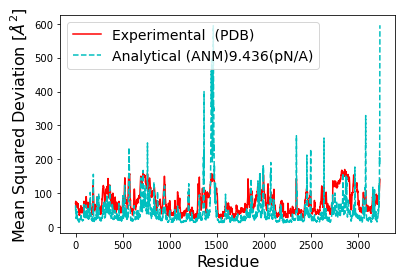

In [9]:
wdir = os.getcwd()

# Coordinates, and chain divider for B-factor figures
coord, bmap = m.get_pdb_info(wdir+ '/examples/RNAP/RNAP_MOD.pdb', returntype='cm')

# The Bfactors are not convserved from the orginal PDB file!!!!!
# B-factors read from a modeller reconstruction are wrong

# The only way currently supported to adjust the experimental B-factors from the orignal PDB file
# to the new length is shown below

# First we need the entire sequence built with Modeller with gaps wherever Modeller inserted a Residue
# We easily get this from the Modeller Protocol used in the Modeller Example
aseq = m.read_seqfile(wdir+'/examples/RNAP/rnap_adjseq.txt') # More details on this later

# Next we fetch the B-factors from the ORIGINAL PDB File
exbfact = m.get_pdb_info(wdir+ '/examples/RNAP/RNAP.pdb', returntype='b')

# Finally we use the sequence to determine where gaps in the experimental B-factors should be placed
# Those gap B-factors that we have no data for are filled using the fillvalue key
nbfacts = m.map_bfactors(aseq, exbfact, fillvalue=70)
coord = coord[:-10]
nbfacts = nbfacts[:-10]

# Now we try out the B-factors again with our reconstructed RNA Polymerase
anm = m.ANM(coord, nbfacts, T=300, cutoff=15)
anm.calc_ANM_unitary(cuda=False)
anm.anm_compare_bfactors_jupyter(bmap=bmap)

## Notice there are still very high peaks in the data, BUT this is OK

    The Origin of our B-factor data is from crystal structures and crystal packing effects can greatly affect
    the data
    
    As a result many flexible Loops show much lower B-factors than expected
    
## Also a couple of peaks were actually added by Modeller, this is OK as Modeller models the missing residues as flexible loops in the given spatial constraints

### Now we will export our Protein to our oxDNA format

In [11]:
m.export_to_simulation(anm, wdir+ '/examples/RNAP/RNAP_MOD4.pdb', upstreamdir='/examples/RNAP')

N =  3244
Wrote Par File to /home/jonah/PycharmProjects/ENM_Protein/examples/RNAP//generated.par
Wrote Configuration (dat) File to /home/jonah/PycharmProjects/ENM_Protein/examples/RNAP//generated.dat
Wrote Topology File to /home/jonah/PycharmProjects/ENM_Protein/examples/RNAP//generated.top


In [12]:
#Rename Simulation Files
!mv ./examples/RNAP/generated.par ./examples/RNAP/rnap.par
!mv ./examples/RNAP/generated.top ./examples/RNAP/rnap.top
!mv ./examples/RNAP/generated.dat ./examples/RNAP/rnap.dat

# 2b. Convert the RNA component to oxDNA format
### Here we make use of an existing conversion server specifcally for the DNA/RNA models of oxDNA

    1. Go to http://tacoxdna.sissa.it/PDB_oxDNA
    2. Upload RNA.pdb and click convert
    3. Save the Output files
        these files are provided as rna.dat and rna.top in /examples/RNAP/


# 3. Combining Components

## For this step, we will use oxView to build our system
    
    1. Open index.html in your browser from the oxView download
    2. Drag and drop the RNAP topology and dat files onto oxView
    3. Drag and drop the RNA topology and dat files onto oxView
    
### This is what you should see

![oxview rnap complex](./examples/imgs/rnap_comp.png)

### The RNA in the RNA polymerase is very tightly interweaved with the protein particles

### Using the power of hindsight, we know this structure will not run as it is due to a myriad of excluded volume problems

    Keep in mind the 3.8 A crystal resolution, to properly place the RNA great care must be taken in 
    positioning each RNA Nucleotide

### Instead, for the purpose of this example we will use a fragment of the full RNA sequence

    We repeat the above steps after refreshing our browser, using the provided 'rnac' topology and dat 
    files instead (provided in examples/RNAP/ directory)
    
    Now we have:
    
![rnac oxview](./examples/imgs/rnac_comp.png)
    
## In Oxviews's current implementation we must upload the Parameter file (rnap.par) to output the correct protein Topology and Parameter file for a DNA/Protein system

    In the system above we simply drap and drop 'rnap.par' onto the system
    
    Now we have:
    
![rnac anm](./examples/imgs/rnac_anm.png)   
    
## This is a view of the ANM network we have created, each bond is drawn (which is why it looks like a mummy)    

    
### Go ahead and download the simulation files by clicking Simulation files in the Top left corner of the oxView menu under 'File'

    We now have the full complex simulation files, save them as 'rnap_complex' .top, .dat, and .par
    files into our (/examples/RNAP/)
    
# NOTE: In the current Implementation of oxView, the Parameter and Dat Files must be manually fixed for any model with Bending/Torsional Interactions

    To see the preparation of involved for these Interactions check out the RNAPT Example
    
    
# 4. Simulation

## Before we can start our MD Simulation, we will need to relax our structure

    Since we have RNA and Protein and we are not using the Torsional/Bonding Modulation we will use 
    the RNANM Interaction type in oxDNA
    
    This relaxation will only involve treating excluded volume interactions. We make use of a Monte Carlo
    Simulation to achieve this (provided as input_MC in the /examples/RNAP/ directory)

In [5]:
# This is a Longer simulation due to the size of the system and the fact it is running on a single core

wdir = os.getcwd()
#Switch Directories to /examples/RNAP/
os.chdir(wdir + '/examples/RNAP/')

# Executable Inputfile (only a 2000 step sim)
!/home/jonah/CLionProjects/oxdna/oxDNA/build/bin/oxDNA input_MC

os.chdir(wdir)

           0  14135486.782335   0.000  0.000  0.000  
        1000   0.133895   0.495  0.772  0.000  
        2000   0.135515   0.495  0.775  0.000  


## The extremely high energy we see at the 0th step is from our excluded volume interaction

    As we can see, the system quickly relaxes

## Saving our 'last_conf.dat' file to 's1.dat' (in /examples/RNAP/) we are now ready for a full fledged CUDA simulation using our RNANM Interaction

In [ ]:
wdir = os.getcwd()

#Switch Directories to /examples/RNAP/
os.chdir(wdir + '/examples/RNAP/')

# Executable Inputfile
!/home/jonah/CLionProjects/oxdna/oxDNA/build/bin/oxDNA input_cuda

os.chdir(wdir)